### Trying to create a model for county by county data for Wisconsin.
- Used the combined data from 2018-19 to 2022-23.
- For 2018-19 academic year, used the population and income data for the year 2018, and so on.
- Income and population data retrieved from the CAINC1 data file released by bea.gov.
- The county ('Shawano') present in Wisconsin AP data but not in CAINC1 file has been manually retrieved (population from census.gov and income from federal reserve in St. Louis).
- Used geopy to compute the average distance between counties and university. We take the five closest universities to compute the average distance.
### Also did naïve modelling with statsmodels
- Used 20% of the 350 datasets as testing data and the rest as training data.
- Percentage of 3 or above score (AKA pass rate) is used as the target variable.
- Per capita income, population and average distance to five closest R1R2, public and private (not for profit) universities are used as features.
- Full model includes all features.
- Uni metric model includes average distance to R1/R2, public and private non-profit as features.
- Non-uni model includes per capita and population as features.
- The p-value of full model compared to uni metric model is extremely low. So, adding non-uni features (population and per capita income) to the uni-metric model improves the model.
- The p-value of full model compared to non-uni model is comparatively larger. So, adding uni-metric features to the economic model (population and per capita income) does not improve the model as much.
- This is also illustrated by root mean squared error (rmse) computation on the tesitng data. The rmse with full model and non-uni model are very similar, whereas that with uni metric model is larger.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import distance

In [160]:
carnegie = pd.read_csv('data/carnegie_with_location.csv')
wisconsin_2223 = pd.read_excel('data/Wisconsin/Wisconsin.xlsx',sheet_name='2022-23')
uscounties = pd.read_csv('data/uscounties.csv')

In [161]:
carnegie

,Unnamed: 0,unitid,name,city,stabbr,basic2000,basic2005,basic2010,basic2015,basic2018,...,hbcu,tribal,hsi,msi,womens,rooms,selindex,address,latitude,longitude
0,0,100654,Alabama A & M University,Normal,AL,16,18,18,18,18,...,1,0,0,1,0,3220,1.0,"4900 Meridian St N, Huntsville, AL 35811, USA",34.783841,-86.572224
1,1,100663,University of Alabama at Birmingham,Birmingham,AL,15,15,15,15,15,...,0,0,0,0,0,2882,2.0,"1720 University Blvd, Birmingham, AL 35294, USA",33.502086,-86.805159
2,2,100690,Amridge University,Montgomery,AL,51,24,24,20,20,...,0,0,0,0,0,0,1.0,"1200 Taylor Rd, Montgomery, AL 36117, USA",32.362671,-86.173926
3,3,100706,University of Alabama in Huntsville,Huntsville,AL,16,16,15,16,16,...,0,0,0,0,0,2200,3.0,"Shelby Center for Science and Technology, 301 ...",34.725161,-86.640471
4,4,100724,Alabama State University,Montgomery,AL,21,18,18,19,19,...,1,0,0,1,0,2079,1.0,"915 S Jackson St, Montgomery, AL 36104, USA",32.362976,-86.293980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,3934,496186,California Institute of Arts & Technology-Nati...,National City,CA,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,NaN,"National City, CA, USA",32.678109,-117.099197
3935,3935,999903,Inter-American Defense College,Washington,DC,-2,-2,-2,-2,32,...,0,0,0,0,0,0,0.0,"210 B St, Washington, DC 20319, USA",38.871030,-77.017851
3936,3936,999907,The Judge Advocate General's School,Charlottesville,VA,-2,-2,-2,-2,32,...,0,0,0,0,0,0,0.0,"Judge Advocate General's School, 600 Massie Rd...",38.054027,-78.507671
3937,3937,999909,United States Army War College,Carlisle,PA,-2,-2,-2,-2,32,...,0,0,0,0,0,0,0.0,"651 Wright Ave, Carlisle, PA 17013, USA",40.211661,-77.172440


In [162]:
uscounties.sample(n=10)

,county,county_ascii,county_full,county_fips,state_id,state_name,lat,lng,population
870,Rutland,Rutland,Rutland County,50021,VT,Vermont,43.5801,-73.0363,60585
1803,Crisp,Crisp,Crisp County,13081,GA,Georgia,31.9229,-83.7681,20255
1570,Montgomery,Montgomery,Montgomery County,37123,NC,North Carolina,35.3325,-79.9055,25839
1857,Kent,Kent,Kent County,24029,MD,Maryland,39.2556,-76.0390,19289
2894,Mason,Mason,Mason County,48319,TX,Texas,30.7177,-99.2261,3959
2790,Floyd,Floyd,Floyd County,48153,TX,Texas,34.0724,-101.3032,5386
1574,Benton,Benton,Benton County,19011,IA,Iowa,42.0802,-92.0657,25652
2361,Hancock,Hancock,Hancock County,19081,IA,Iowa,43.0819,-93.7343,10790
1842,Benton,Benton,Benton County,29015,MO,Missouri,38.2949,-93.2879,19616
1779,Meriwether,Meriwether,Meriwether County,13199,GA,Georgia,33.0406,-84.6883,20679


In [163]:
wisconsin_counties = uscounties[uscounties['state_id'] == 'WI']

In [164]:
wisconsin_counties = wisconsin_counties.reset_index()

In [165]:
wisconsin_counties= wisconsin_counties[['county','lat','lng','population']]

In [166]:
wisconsin_counties

,county,lat,lng,population
0,Milwaukee,43.0072,-87.9669,933063
1,Dane,43.0673,-89.4181,559891
2,Waukesha,43.0182,-88.3045,407290
3,Brown,44.4525,-88.0037,268393
4,Racine,42.7475,-88.0613,197068
...,...,...,...,...
67,Forest,45.6673,-88.7704,9239
68,Pepin,44.5829,-92.0016,7363
69,Iron,46.2623,-90.2420,6136
70,Florence,45.8485,-88.3981,4574


In [167]:
coord1 = (carnegie.iloc[1].latitude,carnegie.iloc[1].longitude)
coord2 = (wisconsin_counties.iloc[1].lat,wisconsin_counties.iloc[1].lng)

In [168]:
distance(coord1,coord2).miles

674.7673624288187

In [169]:
wisconsin_2223

,Unnamed: 0,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE
0,0,Adams,42,79,22,27.848101
1,1,Ashland,25,48,21,43.750000
2,2,Barron,115,178,93,52.247191
3,3,Bayfield,22,34,23,67.647059
4,4,Brown,1875,2903,2066,71.167757
...,...,...,...,...,...,...
64,64,Waukesha,6439,11372,8537,75.070348
65,65,Waupaca,334,460,243,52.826087
66,66,Waushara,60,90,38,42.222222
67,67,Winnebago,840,1122,780,69.518717


In [170]:
wisconsin_2223[wisconsin_2223['COUNTY'].isin(wisconsin_counties['county'].values) == False]

,Unnamed: 0,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE
52,52,Saint Croix,1110,1675,1125,67.164179


In [171]:
wisconsin_counties.iloc[10:30]  #Saint Croix is given as St. Croix in "wisconsin_counties" dataframe.

,county,lat,lng,population
10,Washington,43.3685,-88.2307,136842
11,La Crosse,43.9066,-91.1152,120216
12,Sheboygan,43.7212,-87.9454,117741
13,Eau Claire,44.7268,-91.2860,105697
14,Walworth,42.6685,-88.5419,105127
15,Fond du Lac,43.7536,-88.4883,104027
16,St. Croix,45.0340,-92.4526,93752
17,Ozaukee,43.3840,-87.9509,91745
18,Dodge,43.4163,-88.7075,89032
19,Jefferson,43.0208,-88.7759,85932


In [172]:
wisconsin_2223=wisconsin_2223.replace(to_replace='Saint Croix',value='St. Croix') # Replace 'Saint Croix' by 'St. Croix

In [173]:
carnegie[carnegie['basic2021'].isin([15,16])]

,Unnamed: 0,unitid,name,city,stabbr,basic2000,basic2005,basic2010,basic2015,basic2018,...,hbcu,tribal,hsi,msi,womens,rooms,selindex,address,latitude,longitude
1,1,100663,University of Alabama at Birmingham,Birmingham,AL,15,15,15,15,15,...,0,0,0,0,0,2882,2.0,"1720 University Blvd, Birmingham, AL 35294, USA",33.502086,-86.805159
3,3,100706,University of Alabama in Huntsville,Huntsville,AL,16,16,15,16,16,...,0,0,0,0,0,2200,3.0,"Shelby Center for Science and Technology, 301 ...",34.725161,-86.640471
5,5,100751,The University of Alabama,Tuscaloosa,AL,15,16,16,16,15,...,0,0,0,0,0,8443,2.0,"Tuscaloosa, AL 35487, USA",33.211438,-87.540100
9,9,100858,Auburn University,Auburn,AL,15,16,16,16,15,...,0,0,0,0,0,4823,3.0,"Auburn, AL 36849, USA",32.598055,-85.494267
43,43,102094,University of South Alabama,Mobile,AL,16,18,18,16,16,...,0,0,0,0,0,3217,2.0,"307 N University Blvd, Mobile, AL 36688, USA",30.695941,-88.184236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,3417,445188,University of California-Merced,Merced,CA,-2,-2,-2,16,16,...,0,0,0,0,0,4016,1.0,"5200 Lake Rd, Merced, CA 95343, USA",37.364703,-120.424094
3717,3717,482149,Augusta University,Augusta,GA,21,19,19,16,17,...,0,0,0,0,0,1228,2.0,"1120 15th St, Augusta, GA 30912, USA",33.470909,-81.989885
3744,3744,483124,Arizona State University Digital Immersion,Scottsdale,AZ,-2,-2,-2,17,16,...,0,0,0,0,0,0,0.0,"1151 S Forest Ave, Tempe, AZ, USA",33.422998,-111.927831
3793,3793,486840,Kennesaw State University,Kennesaw,GA,21,18,18,17,16,...,0,0,0,0,0,5116,2.0,"Kennesaw, GA, USA",34.023434,-84.615490


In [174]:
def closest_five(carnegie_univ_data,lat,long):

    # carnegie_univ_data is meant to be sublist/subdataframe of carnegie dataset (with location)
    # lat is meant to be the latitude of the location (usually county)
    # long is meant to be the longitude of the location
    # Returns the average distance to the five closest universities from the supplied list.

    univ_distance = {'unitid':[],'distance':[]}
    for i in carnegie_univ_data.index:
        univ_distance['unitid']=univ_distance['unitid']+[carnegie_univ_data.unitid[i]]
        univ_distance['distance']=univ_distance['distance']+[distance((lat,long),(carnegie_univ_data.latitude[i],carnegie_univ_data.longitude[i])).km]
    univ_distance = pd.DataFrame(univ_distance)
    closest_five = univ_distance.sort_values(by = 'distance')[:5]
    return np.mean(closest_five['distance'].values)

carnegie_r1r2 = carnegie[carnegie['basic2021'].isin([15,16])]
closest_five(carnegie_r1r2,40.902771, -73.133850)  # This is the coordinates of Stony Brook.


44.58800478079978

In [175]:
wisconsin_counties['closest_five_r1r2_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_r1r2,x.lat, x.lng), axis=1)

In [176]:
carnegie_public = carnegie[carnegie['control'] == 1]
wisconsin_counties['closest_five_public_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_public,x.lat, x.lng), axis=1)

In [177]:
carnegie_private_notprofit = carnegie[carnegie['control'] == 2]
wisconsin_counties['closest_five_private_notprofit_avg'] = wisconsin_counties.apply(lambda x: closest_five(carnegie_private_notprofit,x.lat, x.lng), axis=1)

In [178]:
wisconsin_counties

,county,lat,lng,population,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_notprofit_avg
0,Milwaukee,43.0072,-87.9669,933063,71.192526,18.134396,4.867456
1,Dane,43.0673,-89.4181,559891,113.193906,44.510265,43.375766
2,Waukesha,43.0182,-88.3045,407290,79.917138,28.860387,14.591752
3,Brown,44.4525,-88.0037,268393,208.417056,38.004832,42.740848
4,Racine,42.7475,-88.0613,197068,68.747297,27.026131,25.616661
...,...,...,...,...,...,...,...
67,Forest,45.6673,-88.7704,9239,281.722903,100.058392,161.885818
68,Pepin,44.5829,-92.0016,7363,276.837942,45.044858,84.619260
69,Iron,46.2623,-90.2420,6136,319.473656,101.706580,171.946478
70,Florence,45.8485,-88.3981,4574,293.317336,101.963328,168.628280


In [179]:
import data_loaders

In [180]:
incomes = data_loaders.gimmeCountyIncomes()
incomes = incomes[incomes['State_Abbreviation']=='WI']
incomes = pd.concat([pd.DataFrame([['Shawano','WI',42033,43883,46611,50004,50444]], columns=incomes.columns), incomes], ignore_index=True)


In [181]:
incomes

,County,State_Abbreviation,2018,2019,2020,2021,2022
0,Shawano,WI,42033,43883,46611,50004,50444
1,Adams,WI,39048,41159,43993,46112,44696
2,Ashland,WI,38879,40644,43573,46557,46014
3,Barron,WI,47650,49537,54519,56928,58029
4,Bayfield,WI,46098,47552,49990,53818,52963
...,...,...,...,...,...,...,...
66,Waukesha,WI,71073,73569,76931,84113,87582
67,Waupaca,WI,44466,46260,49255,53368,54632
68,Waushara,WI,40346,41135,43781,46976,46697
69,Winnebago,WI,47336,48651,51855,56253,56878


In [182]:
wisconsin_2223[wisconsin_2223['COUNTY'].isin(incomes['County'].values) == False]

,Unnamed: 0,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE


In [183]:
population = data_loaders.gimmeCountyPopulation()
population=population[population['State_Abbreviation']=='WI']
population = pd.concat([pd.DataFrame([['Shawano','WI',40725,40794,40873,40812,40886]], columns=population.columns), population], ignore_index=True)
population

,County,State_Abbreviation,2018,2019,2020,2021,2022
0,Shawano,WI,40725,40794,40873,40812,40886
1,Adams,WI,20533,20431,20675,20795,21226
2,Ashland,WI,16013,16021,16018,16054,16039
3,Barron,WI,46385,46645,46714,46746,46843
4,Bayfield,WI,15872,16062,16233,16304,16608
...,...,...,...,...,...,...,...
66,Waukesha,WI,403616,405563,407467,409080,410434
67,Waupaca,WI,51917,51830,51791,51992,51488
68,Waushara,WI,24401,24563,24549,24797,24999
69,Winnebago,WI,170879,171875,171800,170554,170718


In [184]:
wisconsin_data = {'county':[],'year':[],'population':[],'per_capita_income':[]}
years = ['2018','2019','2020','2021','2022']
for county in incomes['County'].values:
    for year in years:
        wisconsin_data['county'] = wisconsin_data['county']+[county]
        wisconsin_data['year'] = wisconsin_data['year']+[year]
        wisconsin_data['population'] = wisconsin_data['population']+[int(population[population['County'] == county][year].values[0])]
        wisconsin_data['per_capita_income']= wisconsin_data['per_capita_income']+[int(incomes[incomes['County'] == county][year].values[0])]

In [185]:
wisconsin_data = pd.DataFrame(wisconsin_data)
wisconsin_data

,county,year,population,per_capita_income
0,Shawano,2018,40725,42033
1,Shawano,2019,40794,43883
2,Shawano,2020,40873,46611
3,Shawano,2021,40812,50004
4,Shawano,2022,40886,50444
...,...,...,...,...
350,Wood,2018,74085,45262
351,Wood,2019,74205,47142
352,Wood,2020,74197,49588
353,Wood,2021,74085,52678


In [186]:
int(population[population['County'] == 'Adams']['2018'].values[0])

20533

In [187]:
wisconsin_ap = pd.read_csv('data/Wisconsin/Wisconsin_combined.csv')

In [188]:
wisconsin_ap

,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE,Year
0,Adams,45,76,22,28.947368,2018-19
1,Ashland,30,40,25,62.500000,2018-19
2,Barron,132,196,101,51.530612,2018-19
3,Bayfield,10,14,9,64.285714,2018-19
4,Brown,2207,3378,2356,69.745411,2018-19
...,...,...,...,...,...,...
344,Waukesha,6439,11372,8537,75.070348,2022-23
345,Waupaca,334,460,243,52.826087,2022-23
346,Waushara,60,90,38,42.222222,2022-23
347,Winnebago,840,1122,780,69.518717,2022-23


In [189]:
def clean_year(year):
    return year[:-3]
wisconsin_ap['Year']=wisconsin_ap['Year'].apply(clean_year)

In [190]:
wisconsin_ap[(wisconsin_ap['COUNTY'] == 'Adams') & (wisconsin_ap['Year'] == '2018')]

,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE,Year
0,Adams,45,76,22,28.947368,2018


In [191]:
wisconsin_ap=wisconsin_ap.replace(to_replace='Saint Croix',value='St. Croix')

In [192]:
years = ['2018','2019','2020','2021','2022']
pop = []
pci = []
r1r2 = []
public = []
private_notprofit = []
for i in wisconsin_ap.index:
    county = wisconsin_ap.iloc[i].COUNTY
    year = wisconsin_ap.iloc[i].Year
    pop = pop + [wisconsin_data[(wisconsin_data['county']==county) & (wisconsin_data['year'] == year)].population.values[0]]
    pci = pci + [wisconsin_data[(wisconsin_data['county']==county) & (wisconsin_data['year'] == year)].per_capita_income.values[0]]
    r1r2 = r1r2 + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_r1r2_avg.values[0]]
    public = public + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_public_avg.values[0]]
    private_notprofit = private_notprofit + [wisconsin_counties[(wisconsin_counties['county']==county)].closest_five_private_notprofit_avg.values[0]]

wisconsin_ap['population'] = pop
wisconsin_ap['per_capita_income'] = pci
wisconsin_ap['closest_five_r1r2_avg'] = r1r2
wisconsin_ap['closest_five_public_avg'] = public
wisconsin_ap['closest_five_private_notprofit_avg'] = private_notprofit

In [193]:
wisconsin_ap[wisconsin_ap['COUNTY'] == 'Waukesha']

,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE,Year,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_notprofit_avg
65,Waukesha,6567,11729,8535,72.768352,2018,403616,71073,79.917138,28.860387,14.591752
135,Waukesha,6586,11506,8412,73.109682,2019,405563,73569,79.917138,28.860387,14.591752
205,Waukesha,6409,11076,7838,70.765619,2020,407467,76931,79.917138,28.860387,14.591752
275,Waukesha,6329,11029,8202,74.367576,2021,409080,84113,79.917138,28.860387,14.591752
344,Waukesha,6439,11372,8537,75.070348,2022,410434,87582,79.917138,28.860387,14.591752


In [194]:
wisconsin_data[wisconsin_data['county'] == 'Waukesha']

,county,year,population,per_capita_income
330,Waukesha,2018,403616,71073
331,Waukesha,2019,405563,73569
332,Waukesha,2020,407467,76931
333,Waukesha,2021,409080,84113
334,Waukesha,2022,410434,87582


### "wisconsin_ap" is the dataframe that we will use for statistical analysis.

In [195]:
import seaborn as sns

In [196]:
from sklearn.model_selection import train_test_split
training, testing = train_test_split(wisconsin_ap, test_size = 0.2, random_state = 226)

### First, let's draw some plots for exploration.

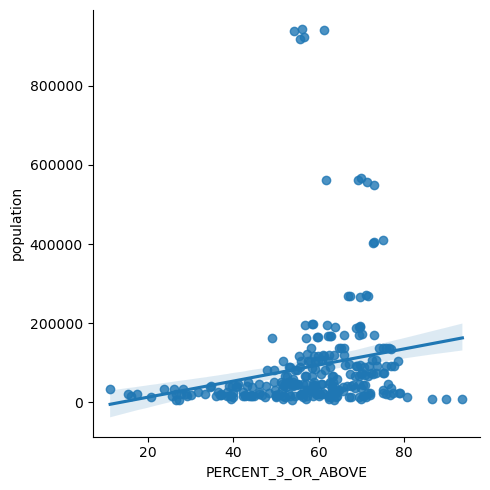

In [197]:
features = ['population','per_capita_income','closest_five_r1r2_avg','closest_five_public_avg','closest_five_private_notprofit_avg']
sns.lmplot(data = training, x='PERCENT_3_OR_ABOVE',y='population')

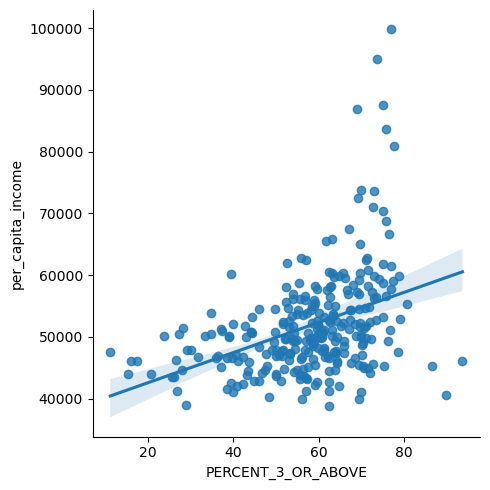

In [198]:
sns.lmplot(data = training, x='PERCENT_3_OR_ABOVE',y='per_capita_income')

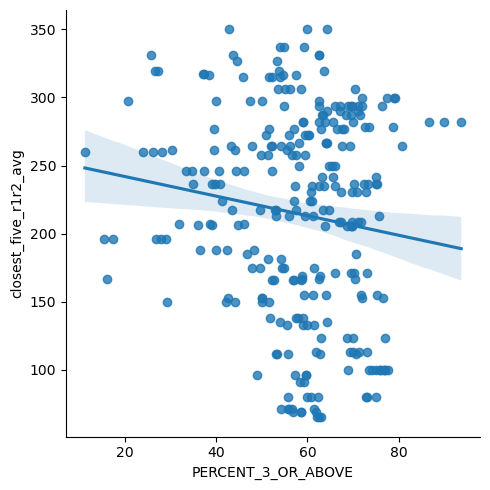

In [199]:
sns.lmplot(data = training, x='PERCENT_3_OR_ABOVE',y='closest_five_r1r2_avg')

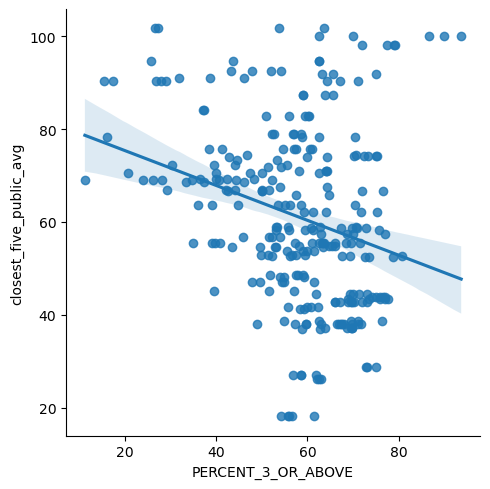

In [200]:
sns.lmplot(data = training, x='PERCENT_3_OR_ABOVE',y='closest_five_public_avg')

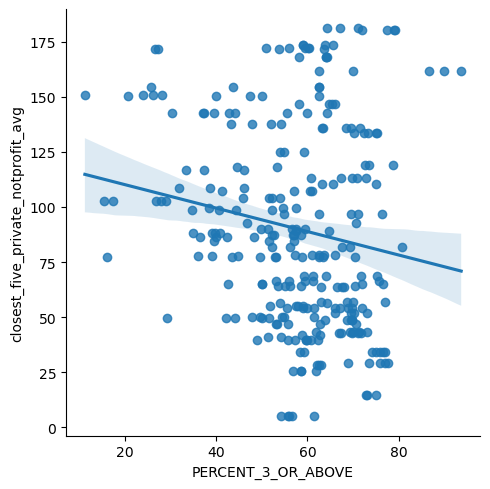

In [201]:
sns.lmplot(data = training, x='PERCENT_3_OR_ABOVE',y='closest_five_private_notprofit_avg')

- Unsurprisingly, the pass rate is positively correlated to socio-economic features per capita income and population.
- However, the pass rate seems to be negatively correlated to the each of the three university metrics.

### Let's do some statistical analysis with statsmodels

In [202]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [203]:
full_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_notprofit_avg + population', data=training).fit()
pci_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income', data =training).fit()
r1r2_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg', data = training).fit()
unimetric_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_notprofit_avg', data = training).fit()
nonuni_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + population', data=training).fit()

In [204]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     PERCENT_3_OR_ABOVE   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     13.02
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           2.27e-11
Time:                        08:00:48   Log-Likelihood:                -1099.7
No. Observations:                 279   AIC:                             2211.
Df Residuals:                     273   BIC:                             2233.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             34.6798      7.233      4.795      0.000      20.440      48.920
per_capita_income                      0.0006   9.65e-05      6.106      0.000       0.000       0.001
closest_five_r1r2_avg                 -0.0035      0.017     -0.206      0.837      -0.037       0.030
closest_five_public_avg               -0.2071      0.068     -3.048      0.003      -0.341      -0.073
closest_five_private_notprofit_avg     0.0661      0.036      1.822      0.070      -0.005       0.138
population                          2.022e-06   6.53e-06      0.309      0.757   -1.08e-05    1.49e-05
==============================================================================
Omnibus:                       17.243   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.268
Skew:                          -0.359   Prob(JB):                     2.67e-07
Kurtosis:                       4.445   Cond. No.                     1.68e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [205]:
f_test_nonuni = full_model.compare_f_test(nonuni_model)
f_test_unimetric = full_model.compare_f_test(unimetric_model)
print("p-value of full compared to non-university metric model:", f_test_nonuni[1])
print("p-value of full compared to university metric model:", f_test_unimetric[1])

p-value of full compared to non-university metric model: 0.02046149321426299
p-value of full compared to university metric model: 1.925566411228037e-08


### The second p-value is extremely small, so unsurprisingly, adding socioeconomic data of income and population to the purely university metric makes for a much better model

### The first p-value is comparatively larger, so adding university metrics does not improve the non-university metric model as much.

In [206]:
predictions_full_model = full_model.predict(testing)  # Compute the predictions using the full model on the testing data
predictions_nonuni_model = nonuni_model.predict(testing) # Compute the predictions using the nonuni model (purely socioeconomic) on the testing data
predictions_unimetric_model = unimetric_model.predict(testing) # Compute the predictions using the unimetric model (university metric) on the testing data

In [211]:
from statsmodels.tools.eval_measures import rmse

rmse_full = rmse(testing['PERCENT_3_OR_ABOVE'], predictions_full_model)
print('root mean squared error with full model is: ',rmse_full)

root mean squared error with full model is:  9.325488460617866


In [210]:
rmse_nonuni = rmse(testing['PERCENT_3_OR_ABOVE'], predictions_nonuni_model)
print('root mean squared error with nonuni model is: ',rmse_nonuni)

root mean squared error with nonuni model is:  9.31961901160709


In [209]:
rmse_uni = rmse(testing['PERCENT_3_OR_ABOVE'], predictions_unimetric_model)
print('root mean squared error with unimetric model is: ',rmse_uni)

root mean squared error with unimetric model is:  10.571795239803619
